正資費MA策略(考慮真實balance)

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

# 使用一個函數獲取所有數據
def fetch_all_data(symbol, timeframe, since, end):
    all_data = []
    while since < end:
        data = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if len(data) == 0:  # 如果沒有新的數據，則跳出循環
            break
        since = data[-1][0] + 1  # 更新時間戳以獲取下一批數據
        all_data.extend(data)
    return all_data

def fetch_and_merge_data(spot_symbol, contract_symbol, exchange, start_date, end_date):
    all_funding_rates = []
    since_timestamp = int(datetime.datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    end_timestamp = int(datetime.datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    last_timestamp = since_timestamp

    # Fetch Spot Price Data
    spot_ohlcv_8h = fetch_all_data(spot_symbol, '8h', since_timestamp, end_timestamp)
    spot_df_8h = pd.DataFrame(spot_ohlcv_8h, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    spot_df_8h['date'] = pd.to_datetime(spot_df_8h['timestamp'], unit='ms')
    # Filter the dataframes based on date
    spot_df_8h = spot_df_8h[(spot_df_8h['date'] >= pd.Timestamp(start_date)) & (spot_df_8h['date'] < pd.Timestamp(end_date))]
    spot_df_8h.set_index('date', inplace=True)

    # Fetch Perpetual Contract Price Data
    ohlcv_8h = fetch_all_data(contract_symbol, '8h', since_timestamp, end_timestamp)
    df_8h = pd.DataFrame(ohlcv_8h, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df_8h['date'] = pd.to_datetime(df_8h['timestamp'], unit='ms')
    df_8h = df_8h[(df_8h['date'] >= pd.Timestamp(start_date)) & (df_8h['date'] < pd.Timestamp(end_date))]

    # Fetch Funding Rates
    while last_timestamp < end_timestamp:
        funding_rates = exchange.fetchFundingRateHistory(contract_symbol, since=last_timestamp, params={"endTime": end_timestamp})
        if not funding_rates:
            break
        all_funding_rates.extend(funding_rates)
        last_timestamp = funding_rates[-1]['timestamp'] + 1

    funding_df = pd.DataFrame(all_funding_rates)
    funding_df['date'] = pd.to_datetime(funding_df['timestamp'], unit='ms')
    funding_df['adjusted_timestamp'] = (funding_df['timestamp'] // (8 * 60 * 60 * 1000)) * (8 * 60 * 60 * 1000)
    funding_df['adjusted_date'] = pd.to_datetime(funding_df['adjusted_timestamp'], unit='ms')
    funding_df.set_index('adjusted_date', inplace=True)

    # Merge Data
    merged_df = df_8h.merge(spot_df_8h[['close']], on='date', how='left', suffixes=('', '_spot'))
    merged_df = merged_df.merge(funding_df[['fundingRate']], left_on='date', right_on='adjusted_date', how='left')
    merged_df.set_index('timestamp', inplace=True)
    merged_df.rename(columns={'close': 'close_contract'}, inplace=True)
    
    return merged_df[['close_contract', 'close_spot', 'fundingRate']]

# Define coins and their contract counterparts
coins = ['BTC', 'ETH', 'XRP', 'ADA', 'DOT', 'LINK', 'LTC', 'BCH', 'XLM', 'UNI']
exchange = ccxt.binance()
start_date = '2020-01-01'
end_date = '2023-01-01'

results = {}

# Iterate through each coin, fetch and merge the data
for coin in coins:
    spot_symbol = f"{coin}/USDT"
    contract_symbol = f"{coin}/USDT:USDT"
    results[coin] = fetch_and_merge_data(spot_symbol, contract_symbol, exchange, start_date, end_date)



In [2]:
results.keys()

dict_keys(['BTC', 'ETH', 'XRP', 'ADA', 'DOT', 'LINK', 'LTC', 'BCH', 'XLM', 'UNI'])

In [3]:
results['BTC']

,close_contract,close_spot,fundingRate
timestamp,,,
1577836800000,7205.26,7209.83,-0.000124
1577865600000,7229.49,7234.19,-0.000124
1577894400000,7197.57,7200.85,-0.000097
1577923200000,7107.56,7110.57,0.000037
1577952000000,7126.25,7130.98,0.000100
...,...,...,...
1672387200000,16547.70,16555.26,0.000071
1672416000000,16601.20,16607.48,0.000100
1672444800000,16564.40,16565.09,0.000100


觀察raw data fundingrate

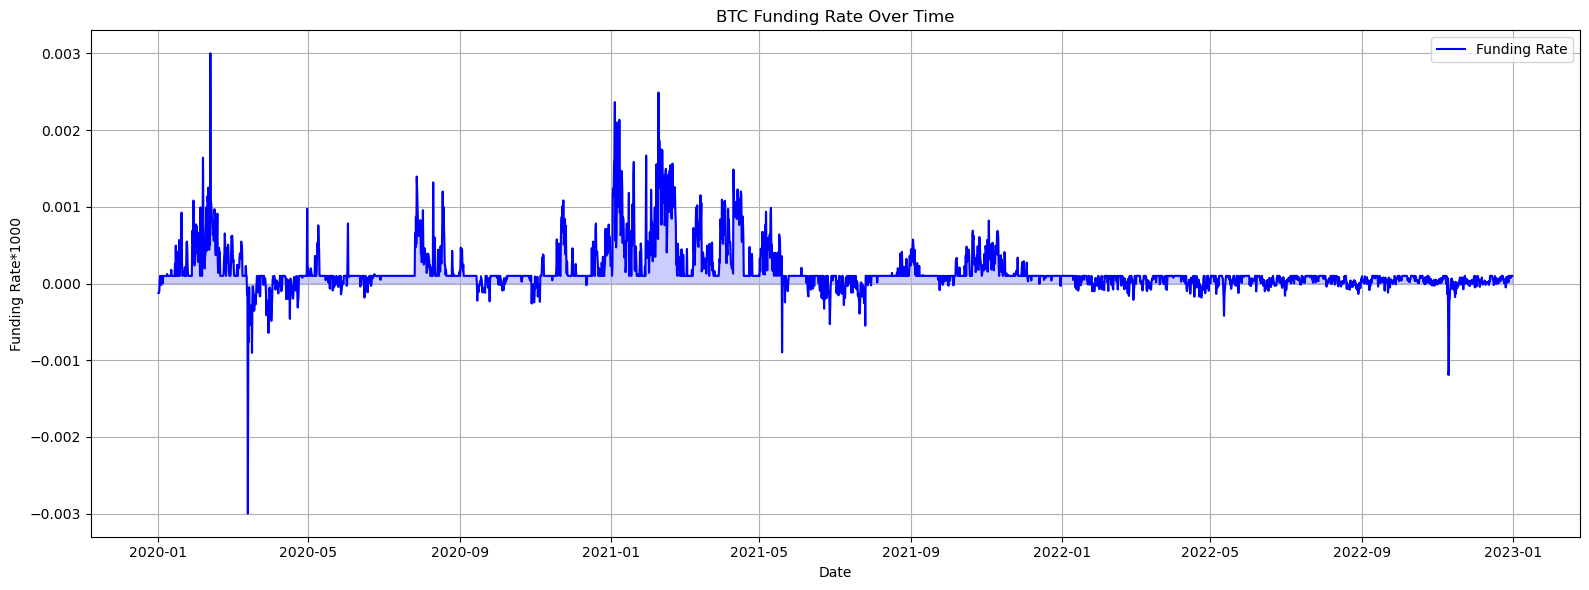

In [4]:
checkout = 'BTC'
# 轉換timestamp為可讀的日期
results[checkout].index = pd.to_datetime(results[checkout].index, unit='ms')

# 繪製資金費率
plt.figure(figsize=(16, 6))
plt.plot(results[checkout].index, results[checkout]['fundingRate'], label='Funding Rate', color='blue')
plt.fill_between(results[checkout].index, results[checkout]['fundingRate'], color='blue', alpha=0.2)
plt.title(f'{checkout} Funding Rate Over Time')  # 使用f-string格式化
plt.xlabel('Date')
plt.ylabel('Funding Rate*1000')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


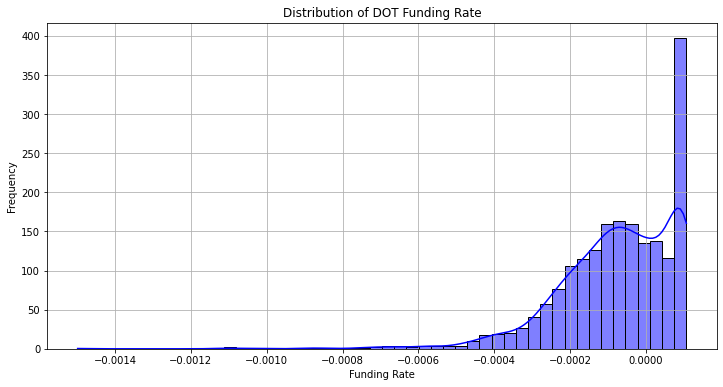

In [24]:
import seaborn as sns
# 提取資金費率數據
funding_rate_data = results[checkout]['fundingRate']

plt.figure(figsize=(12, 6))
sns.histplot(funding_rate_data, bins=50, kde=True, color="blue")
plt.title(f'Distribution of {checkout} Funding Rate')
plt.xlabel('Funding Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

策略邏輯 : funding_rate_ma > 0

In [5]:
def calculate_strategy(df):
    """
    Given a DataFrame with funding rates, calculate and return strategy signals.
    """
    # 計算10日資金費率平均
    # df['funding_rate_10d_mean'] = df['fundingRate'].rolling(window=15).mean()
    
    # df['long_signal'] = (df['fundingRate'] > df['funding_rate_10d_mean']) & (df['funding_rate_10d_mean'] > 0)
    
    # 進場邏輯
    df['long_signal'] = (df['fundingRate'] > 0) & (df['fundingRate'].rolling(window=9).mean().shift(1) > 0)
    # (volitilty)filter

    # 出場邏輯
    df['exit_signal'] = df['fundingRate'].rolling(window=9).mean().shift(1) < 0

    return df

# Apply the strategy for each coin
strategy_results = {}
for coin, df in results.items():
    strategy_results[coin] = calculate_strategy(df)

# Now, strategy_results contains strategy signals for each coin


In [6]:
strategy_results['BTC']

,close_contract,close_spot,fundingRate,long_signal,exit_signal
timestamp,,,,,
1577836800000,7205.26,7209.83,-0.000124,False,False
1577865600000,7229.49,7234.19,-0.000124,False,False
1577894400000,7197.57,7200.85,-0.000097,False,False
1577923200000,7107.56,7110.57,0.000037,False,False
1577952000000,7126.25,7130.98,0.000100,False,False
...,...,...,...,...,...
1672387200000,16547.70,16555.26,0.000071,True,False
1672416000000,16601.20,16607.48,0.000100,True,False
1672444800000,16564.40,16565.09,0.000100,True,False


回測

In [7]:
def backtest_strategy(df):
    initial_balance = 10000  # 初始資金
    balance = initial_balance
    in_position = False
    df['actual_long_entry'] = False
    df['actual_exit'] = False

    entry_spot_price = 0
    entry_contract_price = 0
    
    # cost 
    trading_fee = 0.0005  # 0.05%

    df['pct_change_contract'] = df['close_contract'].pct_change()
    df['pct_change_spot'] = df['close_spot'].pct_change()

    for index, row in df.iterrows():
        if row['long_signal'] and not in_position:
            # 做多現貨, 做空合約
            in_position = True
            df.at[index, 'actual_long_entry'] = True
            entry_spot_price = row['close_spot']
            entry_contract_price = row['close_contract']

            # 進場一買一賣 : fee 
            balance -= balance * trading_fee 

        elif row['exit_signal'] and in_position:
            # 平倉
            in_position = False
            df.at[index, 'actual_exit'] = True
            '''
            # 考慮現貨和合約的價格差異
            profit_spot = balance * (row['close_spot'] - entry_spot_price) / entry_spot_price
            profit_contract = balance * (entry_contract_price - row['close_contract']) / entry_contract_price
            balance += profit_spot + profit_contract
            '''

            balance -= balance * trading_fee 
            
        # 考慮資金費率的影響，並考慮balance變動的影響
        if in_position:
            # 真實 balance
            origin = balance
            balance += origin * row['pct_change_spot']
            balance -= origin * row['pct_change_contract']
            balance += balance * row['fundingRate']
            
        df.at[index, 'balance'] = balance
            

    # 計算最後的餘額
    final_balance = balance
    return final_balance

# Apply the backtest for each coin and save final balances
final_balances = {}
for coin, df in strategy_results.items():
    final_balances[coin] = backtest_strategy(df)

# Now, final_balances contains the final balance for each coin
# You can sort them to see which coin performed best
sorted_balances = sorted(final_balances.items(), key=lambda x: x[1], reverse=True)
print(sorted_balances)


[('XLM', 22373.89882733077), ('XRP', 20284.019466086804), ('ADA', 19284.735559318477), ('LTC', 19263.219469499814), ('LINK', 19142.403198690285), ('ETH', 19033.009693025153), ('BCH', 18314.271007705316), ('UNI', 16992.407321380553), ('BTC', 16603.699283791862), ('DOT', 16251.34506192223)]


績效圖

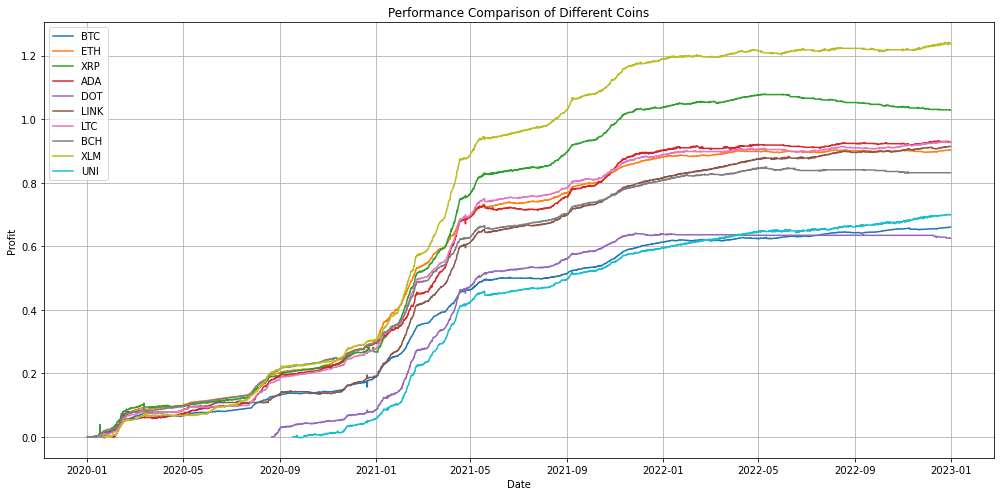

In [18]:
plt.figure(figsize=(14, 7))

for coin, df in results.items():
    # 將timestamp索引轉換為日期時間格式
    df.index = pd.to_datetime(df.index, unit='ms')
    plt.plot(df.index, (df['balance']-10000)/10000, label=coin)

plt.title("Performance Comparison of Different Coins")
plt.ylabel("Profit")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
results['UNI']['actual_long_entry'].sum()

23

In [10]:
def sharpe_ratio(returns, risk_free_rate=0, days_per_year=365):
    mean_return = returns.mean() * days_per_year
    return_std = returns.std() * np.sqrt(days_per_year)
    return (mean_return - risk_free_rate) / return_std

def calmar_ratio(returns, max_drawdown, days_per_year=365):
    mean_return = returns.mean() * days_per_year
    return mean_return / abs(max_drawdown)

def sortino_ratio(returns, risk_free_rate=0, days_per_year=365, target=0):
    mean_return = returns.mean() * days_per_year
    downside_std = returns[returns < target].std() * np.sqrt(days_per_year)
    return (mean_return - risk_free_rate) / downside_std

def max_drawdown(balance):
    max_balance = balance.expanding().max()
    drawdown = (balance - max_balance) / max_balance
    return drawdown.min()

def annual_percentage_yield(balance, days_per_year=365):
    total_days = (balance.index[-1] - balance.index[0]).days
    return (balance[-1] / balance[0]) ** (days_per_year / total_days) - 1


績效表

In [11]:
metrics_df = pd.DataFrame(columns=['Coin', 'Sharpe', 'Calmar', 'Sortino', 'MDD', 'APY'])

for coin, df in results.items():
    daily_returns = df['balance'].pct_change().dropna()
    MDD = max_drawdown(df['balance'])
    APY = annual_percentage_yield(df['balance'])

    metrics_df = metrics_df.append({
        'Coin': coin,
        'Sharpe': sharpe_ratio(daily_returns),
        'Calmar': calmar_ratio(daily_returns, MDD),
        'Sortino': sortino_ratio(daily_returns),
        'MDD': MDD,
        'APY': APY
    }, ignore_index=True)



C:\Users\吳松樺\AppData\Local\Temp\ipykernel_13404\1541562266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({
C:\Users\吳松樺\AppData\Local\Temp\ipykernel_13404\1541562266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({
C:\Users\吳松樺\AppData\Local\Temp\ipykernel_13404\1541562266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({
C:\Users\吳松樺\AppData\Local\Temp\ipykernel_13404\1541562266.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({
C:\Users\吳松樺\AppData\Local\Temp\ipykernel_13404\1541562266.py:8: Fut

In [12]:
metrics_df

,Coin,Sharpe,Calmar,Sortino,MDD,APY
0,BTC,4.463611,3.417799,4.812388,-0.016498,0.184136
1,ETH,5.059144,5.099628,7.138170,-0.014035,0.239279
2,XRP,3.566616,2.465426,3.809686,-0.032114,0.267227
3,ADA,4.384819,8.351604,7.067081,-0.008999,0.252418
4,DOT,4.074125,6.883517,5.485746,-0.009982,0.228574
5,LINK,4.212602,8.348649,6.404761,-0.008786,0.245640
6,LTC,4.997790,7.630677,8.673621,-0.009629,0.246258
7,BCH,4.583071,5.688700,5.780930,-0.011832,0.223479
8,XLM,4.792011,10.126687,7.917015,-0.009008,0.314132
9,UNI,3.719368,8.450283,5.516096,-0.009172,0.261162
